In [ ]:
import numpy as np
import pywt

import seaborn as sns #绘制confusion matrix heatmap

import os
import scipy.io as sio

from sklearn.decomposition import PCA

from python_speech_features import mfcc as pmfcc

import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

import gc

In [ ]:
import warnings
warnings.simplefilter('ignore') #忽略警告

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

import xgboost

In [ ]:
from keras.utils import to_categorical

In [ ]:
sample_rate = 256
origin_channel = 8


SAMPLE_CHANNEL = ['Pz' , 'PO3' , 'PO4' , 'O1' , 'O2' , 'Oz' , 'O9' , 'FP2' ,
                  'C4' , 'C6' , 'CP3' , 'CP1' ,
                  'CPZ' , 'CP2' , 'CP4' , 'PO8']

LABEL2STR = {0:'sen' , 1:'hong' , 2:'zhao',
             3:'fen' , 4:'xiao' , 5:'yu' , 
             6:'bin' , 7:'wang' , 8:'wei' , 
             9:'fei'}

CLIP_FORWARD = 1 #首部裁掉时间
CLIP_BACKWARD = 1 #尾部裁掉时间

trial_time = 3 #segment second


#是否进行归一化
#reference:a study on performance increasing in ssvep based bci application
#IS_NORMALIZE = True

#是否进行滤波
#IS_FILTER = False
#EEG频率范围
#reference:a study on performance increasing in ssvep based bci application
LO_FREQ = 0.5
HI_FREQ = 40

#是否陷波
#IS_NOTCH = False
NOTCH_FREQ = 50 #陷波 工频


In [ ]:
def load_data(filename):

    data = sio.loadmat(file_name=filename)['data_received'] #length*16 matrix

    data = data[CLIP_FORWARD * sample_rate : - CLIP_BACKWARD * sample_rate] #首部 尾部 进行裁剪
   
    return data[:,[0,1,2,3,4,5,6,15]] #只使用枕叶位置的脑电信号 

In [ ]:
def separate(data , label , overlap_length):
    '''
    最长重叠长度为size长 256*3 个数据点
    '''
    train_data = []
    train_labels = []

    size = sample_rate * trial_time #一小段 256*3 个数据点
    data_length = data.shape[0]

    idx = 0
    
    while idx<=data_length-size:
        train_data.append(data[idx : idx+size , :])
        train_labels.append(label)

        idx = idx + (size - overlap_length)
        
    return np.array(train_data) , np.array(train_labels)

In [ ]:
def shuffle_t_v(filenames):
    # np.random.shuffle(filenames)
    
    return np.random.choice(filenames , size=10) #20次的计算准确率中 每次随机选择10个样本进行训练测试

def combine(freq):    
    overlap_length = 2*256 #重叠2秒数据
    
    #保证随机性 进行置乱
    person_0_filenames = shuffle_t_v( os.listdir('base_rf/%s/0/' % freq) )
    person_1_filenames = shuffle_t_v( os.listdir('base_rf/%s/1/' % freq) )
    person_2_filenames = shuffle_t_v( os.listdir('base_rf/%s/2/' % freq) )
    person_3_filenames = shuffle_t_v( os.listdir('base_rf/%s/3/' % freq) )
    person_4_filenames = shuffle_t_v( os.listdir('base_rf/%s/4/' % freq) )
    person_5_filenames = shuffle_t_v( os.listdir('base_rf/%s/5/' % freq) )
    person_6_filenames = shuffle_t_v( os.listdir('base_rf/%s/6/' % freq) )
    person_7_filenames = shuffle_t_v( os.listdir('base_rf/%s/7/' % freq) )
    person_8_filenames = shuffle_t_v( os.listdir('base_rf/%s/8/' % freq) )

    #打开信号文件 并 合并
    person_0 = np.concatenate([load_data('base_rf/%s/0/' % freq + filename) for filename in person_0_filenames] , axis = 0)
    person_1 = np.concatenate([load_data('base_rf/%s/1/' % freq + filename) for filename in person_1_filenames] , axis = 0)
    person_2 = np.concatenate([load_data('base_rf/%s/2/' % freq + filename) for filename in person_2_filenames] , axis = 0)
    person_3 = np.concatenate([load_data('base_rf/%s/3/' % freq + filename) for filename in person_3_filenames] , axis = 0)
    person_4 = np.concatenate([load_data('base_rf/%s/4/' % freq + filename) for filename in person_4_filenames] , axis = 0)
    person_5 = np.concatenate([load_data('base_rf/%s/5/' % freq + filename) for filename in person_5_filenames] , axis = 0)
    person_6 = np.concatenate([load_data('base_rf/%s/6/' % freq + filename) for filename in person_6_filenames] , axis = 0)
    person_7 = np.concatenate([load_data('base_rf/%s/7/' % freq + filename) for filename in person_7_filenames] , axis = 0)
    person_8 = np.concatenate([load_data('base_rf/%s/8/' % freq + filename) for filename in person_8_filenames] , axis = 0)
    
    #============
    #训练数据分段
    train_person_data_0 , train_person_labels_0 = separate(person_0 , label = 0 , overlap_length=overlap_length)
    train_person_data_1 , train_person_labels_1 = separate(person_1 , label = 1 , overlap_length=overlap_length)
    train_person_data_2 , train_person_labels_2 = separate(person_2 , label = 2 , overlap_length=overlap_length)
    train_person_data_3 , train_person_labels_3 = separate(person_3 , label = 3 , overlap_length=overlap_length)
    train_person_data_4 , train_person_labels_4 = separate(person_4 , label = 4 , overlap_length=overlap_length)
    train_person_data_5 , train_person_labels_5 = separate(person_5 , label = 5 , overlap_length=overlap_length)
    train_person_data_6 , train_person_labels_6 = separate(person_6 , label = 6 , overlap_length=overlap_length)
    train_person_data_7 , train_person_labels_7 = separate(person_7 , label = 7 , overlap_length=overlap_length)
    train_person_data_8 , train_person_labels_8 = separate(person_8 , label = 8 , overlap_length=overlap_length)

    #合并数据
    train_data = np.concatenate((train_person_data_0 , train_person_data_1 , train_person_data_2 ,
                                 train_person_data_3 , train_person_data_4 , train_person_data_5 ,
                                 train_person_data_6 , train_person_data_7 , train_person_data_8 ,
                                 ))
    
    train_labels = np.concatenate((train_person_labels_0 , train_person_labels_1 , train_person_labels_2 ,
                                   train_person_labels_3 , train_person_labels_4 , train_person_labels_5 ,
                                   train_person_labels_6 , train_person_labels_7 , train_person_labels_8 ,
                                    ))
    
    #产生索引并置乱
    idx_train_data = list(range(train_data.shape[0]))
    np.random.shuffle(idx_train_data)

    #将训练数据置乱
    train_data = train_data[idx_train_data]
    train_labels = train_labels[idx_train_data]
        
    return train_data , train_labels


In [ ]:
def session_data_labels(session_id , freq , is_training):
    if is_training:
        overlap_length = 256*2
    else:
        overlap_length = 0
    
    str_freq = str(freq)
    
    subjcets = os.listdir('incremental/%s/s%d/' % (str_freq , session_id)) #受试者ID
    
    data = []
    labels = []
    
    for subjcet in subjcets:
        filenames = os.listdir('incremental/%s/s%d/%s/' % (str_freq , session_id , subjcet))
        
        person = np.concatenate([load_data('incremental/%s/s%d/%s/%s' % (str_freq , session_id , subjcet , filename)) for filename in filenames] , axis = 0)
        
        person_data , person_label = separate( person , label = int(subjcet) , overlap_length = overlap_length)
        
        data.append(person_data)
        labels.append(person_label)
    
    #合并数据
    data = np.concatenate(data)
    labels = np.concatenate(labels)
    
    #shuffle
    idx_data = list(range(data.shape[0]))
    np.random.shuffle(idx_data)

    data = data[idx_data]
    labels = labels[idx_data]
    
    return data , labels


In [ ]:
def mfcc(data):
    
    X = []
   
    for i in range(8):
        X.append( pmfcc( data[: , i] , samplerate=256).reshape([1 , -1]).squeeze() )
        
    return np.array( X ).reshape([1 , -1]).squeeze()

def feature_extraction_mfcc(data):
    X = []
    
    for datum in data:
        X.append( mfcc(datum) )

    return np.array(X)

In [ ]:
def concat_and_shuffle(orig_X , orig_y , session_id , freq):
    session_id_data , session_id_labels = session_data_labels(session_id , freq , is_training=True)
    session_id_data = feature_extraction_mfcc(session_id_data)
    # session_id_labels = to_categorical(session_id_labels , num_classes=9)
    
    orig_X = np.concatenate((orig_X , session_id_data) , axis=0)
    orig_y = np.concatenate((orig_y , session_id_labels) , axis=0)
    
    idx = list(range(orig_X.shape[0]))
    np.random.shuffle(idx)
    
    orig_X = orig_X[idx]
    orig_y = orig_y[idx]
    
    return orig_X , orig_y

In [ ]:
def concat_and_shuffle_2(session_id , freq):
    session_id_data , session_id_labels = session_data_labels(session_id , freq , is_training=True)
    session_id_data = feature_extraction_mfcc(session_id_data)
    # session_id_labels = to_categorical(session_id_labels , num_classes=9)
    
    orig_X = np.concatenate((orig_X , session_id_data) , axis=0)
    orig_y = np.concatenate((orig_y , session_id_labels) , axis=0)
    
    idx = list(range(orig_X.shape[0]))
    np.random.shuffle(idx)
    
    orig_X = orig_X[idx]
    orig_y = orig_y[idx]
    
    return orig_X , orig_y

In [ ]:
for freq in [8.5 , 10]:
    #基分类器使用随机森林
    train_X_ , train_y = combine(freq=freq) #6 7.5 8.5 10 hz
    
    train_X = feature_extraction_mfcc(train_X_) #SBP特征提取
    # train_y = to_categorical(train_y_ , num_classes=9) #one-hot化
    pca = PCA(n_components=32)
    pca.fit(train_X)
    train_X_decomp = pca.transform(train_X)
    
    gbdt = GradientBoostingClassifier()
    gbdt.fit(train_X_decomp , train_y)
    
    for session_id in [1,3,5,6,7,8,9,11,12,13]:
        session_N_data , session_N_labels = session_data_labels(session_id , freq , is_training=False)
        session_N_data = feature_extraction_mfcc(session_N_data)
        session_N_data = pca.transform(session_N_data)
        # session_N_labels = to_categorical(session_N_labels , num_classes=9)

        print( freq , session_id , gbdt.score(session_N_data , session_N_labels) )

        #更新模型
        #session_id_data , session_id_labels = session_data_labels(session_id , freq , is_training=True)
        #session_id_data = feature_extraction_mfcc(session_id_data)
        #session_id_data = pca.transform(session_id_data)
        #
        #rf.fit(session_id_data , session_id_labels)
        
        train_X , train_y = concat_and_shuffle(train_X , train_y , session_id , freq)
        
        pca = PCA(n_components=32)
        pca.fit(train_X)
        train_X_decomp = pca.transform(train_X)
        
        gbdt = GradientBoostingClassifier()
        gbdt.fit(train_X_decomp , train_y)
    
    gc.collect()

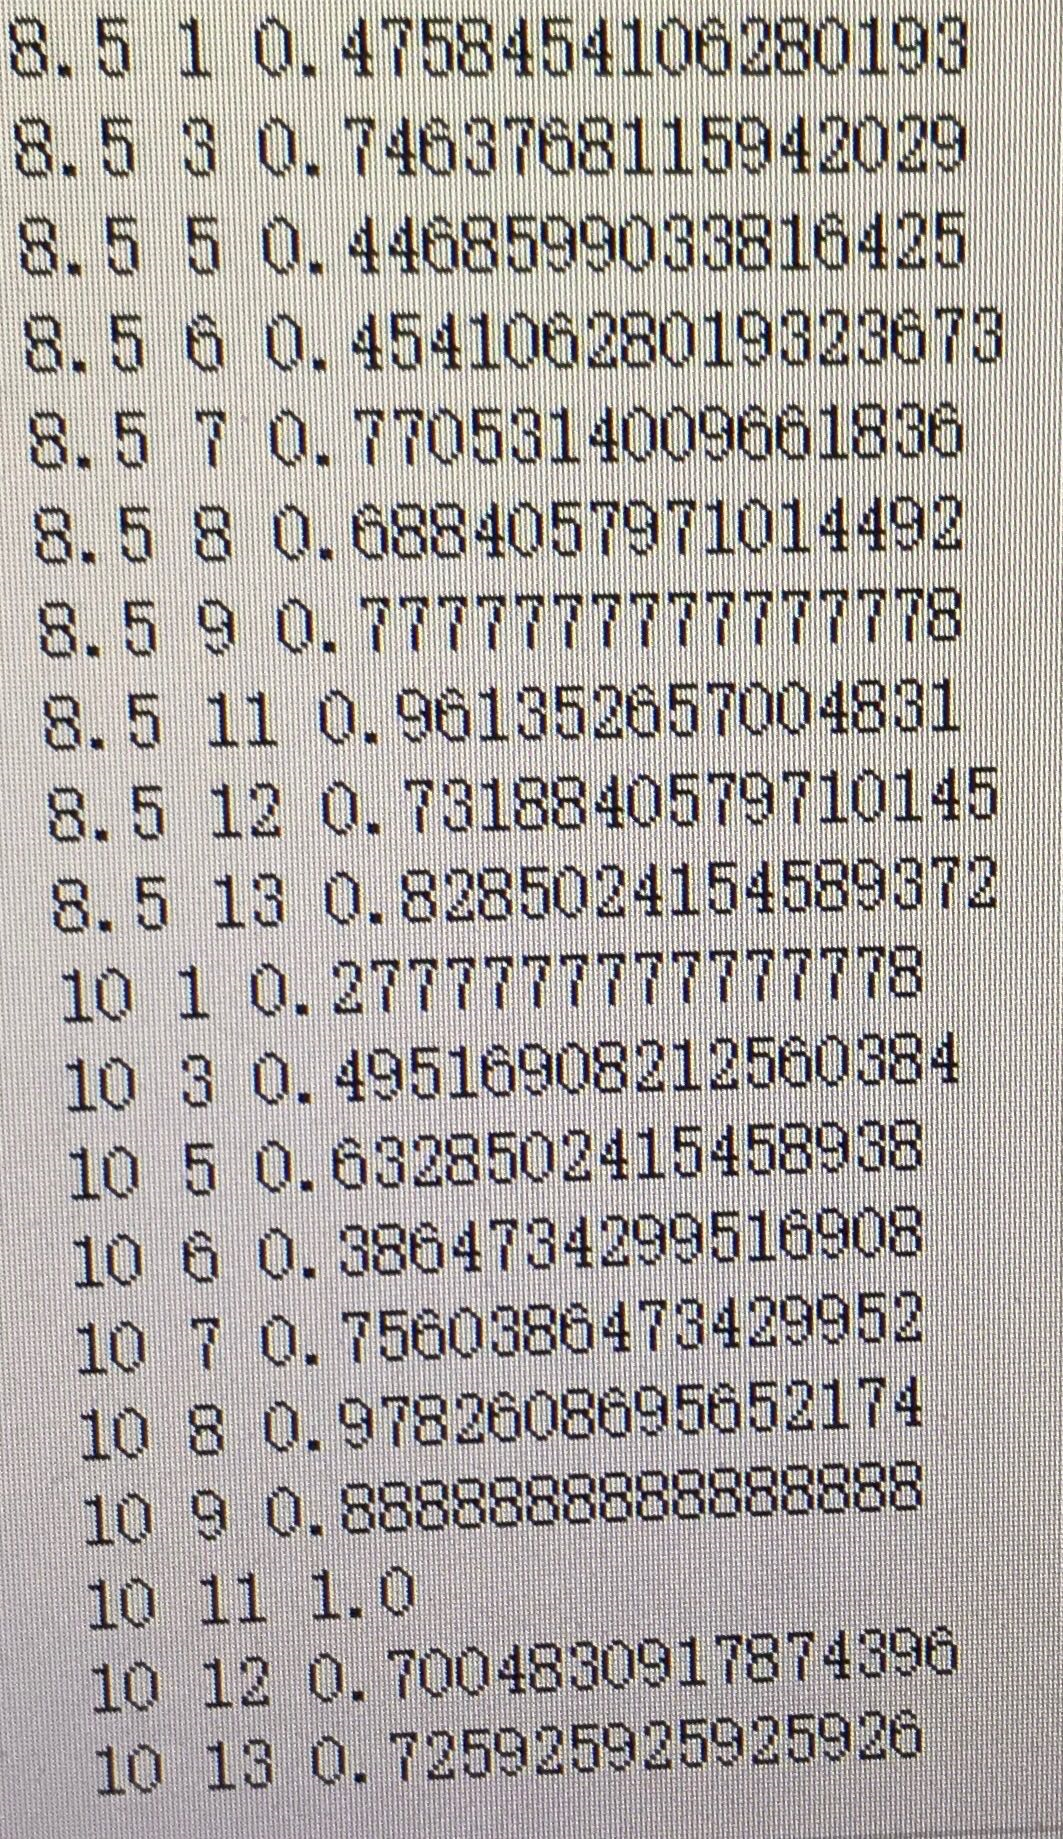

In [ ]:
0.4106280193236715
0.6642512077294686
0.2995169082125604
0.5265700483091788
0.9347826086956522
0.8502415458937198
0.45893719806763283
0.9082125603864735
0.8429951690821256
0.748792270531401

0.3188405797101449
0.7294685990338164
0.9927536231884058
0.6714975845410628
0.5
0.7270531400966184
0.8333333333333334
0.8526570048309179
0.8961352657004831
0.5

0.4758454106
0.7463768116
0.446859903
0.454106280
0.770531401
0.688405797
0.77777777778
0.961352657
0.7318840579
0.8285024154

0.277777778
0.49516908
0.6328502415
0.38647343
0.756038647
0.97826087
0.888888889
1.0
0.7004830917
0.725925926